   Author: Ankit Kariryaa, University of Bremen
      
   Modified by Jiawei Wei

### Getting started
Define the paths to the dataset and trained models in the `notebooks/config/UNetTraining.py` file.  

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import rasterio
import imgaug as ia
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imageio
import os
import time
import rasterio.warp             # Reproject raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses_FTL import focalTversky, accuracy, dice_coef, dice_loss, specificity, sensitivity, PA, IoU_Pos, IoU_Neg, mIoU, F1_Score
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo
from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset, cross_validation_split
from core.visualize import display_images
from tqdm import tqdm
import json
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(tf.__version__)
tf.test.gpu_device_name()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# # In case you want to use multiple GPU you can uncomment the following lines.
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops=tf.distribute.ReductionToOneDevice())
# print('Number of devices: %d' % strategy.num_replicas_in_sync)

config = ConfigProto(
    #device_count={"CPU": 64},
    allow_soft_placement=True, 
    log_device_placement=False)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.7 
session = InteractiveSession(config=config)

In [5]:
#Mixed precision
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

In [6]:
# Required configurations (including the input and output paths) are stored in a separate file (such as config/UNetTraining.py)
# Please provide required info in the file before continuing with this notebook. 
 
from config import UNetTraining_withLocation
# In case you are using a different folder name such as configLargeCluster, then you should import from the respective folder 
# Eg. from configLargeCluster import UNetTraining
config = UNetTraining_withLocation.Configuration()

In [7]:
# Read all images/frames into memory
frames = []

all_files = os.listdir(config.base_dir)
# print(all_files)

all_files_WST = [fn for fn in all_files if fn.startswith(config.WST_fn) and fn.endswith(config.image_type)]
# count delta img
len(all_files_WST)
for i, fn in enumerate(tqdm(all_files_WST)):
    WST_img = rasterio.open(os.path.join(config.base_dir, fn))
    read_WST_img = WST_img.read()
    read_WST_img = np.nan_to_num(read_WST_img, nan=-255)#convert nan to 255.
    comb_img = read_WST_img 
    comb_img = np.transpose(comb_img, axes=(1,2,0)) #Channel at the end
    annotation_im = rasterio.open(os.path.join(config.base_dir, fn.replace(config.WST_fn,config.annotation_fn)))
    annotation = annotation_im.read()[0]
    f = FrameInfo(comb_img, annotation)
    frames.append(f)

3841

100%|██████████████████████████████████████████████████████████████████████████████| 3841/3841 [07:20<00:00,  8.72it/s]


In [8]:
training_frames, validation_frames, testing_frames  = split_dataset(frames, config.frames_json, config.patch_dir)
# cross_validation_split(frames, config.frames_json, config.patch_dir)
# training_frames = validation_frames = testing_frames  = list(range(len(frames)))

annotation_channels = config.input_label_channel 
train_generator = DataGenerator(config.input_image_channel, config.patch_size, training_frames, frames, annotation_channels, augmenter = 'iaa').random_generator(config.BATCH_SIZE, normalize = config.normalize)
val_generator = DataGenerator(config.input_image_channel, config.patch_size, validation_frames, frames, annotation_channels, augmenter= None).random_generator(config.BATCH_SIZE, normalize = config.normalize)
test_generator = DataGenerator(config.input_image_channel, config.patch_size, testing_frames, frames, annotation_channels, augmenter= None).random_generator(config.BATCH_SIZE, normalize = config.normalize)
print(train_generator)

Reading train-test split from file
training_frames [838, 1946, 1578, 2501, 287, 2536, 1199, 1358, 850, 3252, 3037, 840, 36, 1618, 3226, 1495, 3092, 562, 564, 12, 3099, 1482, 2311, 2011, 847, 3276, 566, 2508, 349, 310, 670, 2304, 2922, 3270, 1621, 1729, 280, 666, 3241, 2308, 2309, 59, 3225, 3044, 1050, 455, 557, 2483, 550, 1746, 2495, 3036, 1610, 5, 1487, 294, 1850, 2323, 336, 3245, 21, 1376, 3255, 323, 24, 2312, 1941, 559, 1848, 680, 2013, 1633, 296, 18, 1373, 1635, 1749, 3231, 3244, 3090, 44, 371, 3247, 1637, 1379, 53, 1365, 335, 1952, 285, 469, 1498, 359, 2012, 3034, 1619, 1922, 374, 458, 675, 667, 2488, 304, 2252, 3251, 2857, 2270, 55, 362, 785, 327, 1370, 54, 1198, 778, 980, 2507, 1953, 33, 2500, 2509, 1951, 2277, 551, 10, 2491, 1957, 1947, 1047, 2526, 314, 1607, 273, 1732, 11, 274, 322, 1388, 569, 2268, 2315, 3087, 3032, 2258, 3235, 2317, 2527, 1045, 841, 1481, 2279, 468, 1364, 3239, 2257, 2261, 3260, 3274, 1581, 3277, 286, 1056, 34, 679, 1626, 1490, 2523, 2319, 0, 14, 555, 2307, 

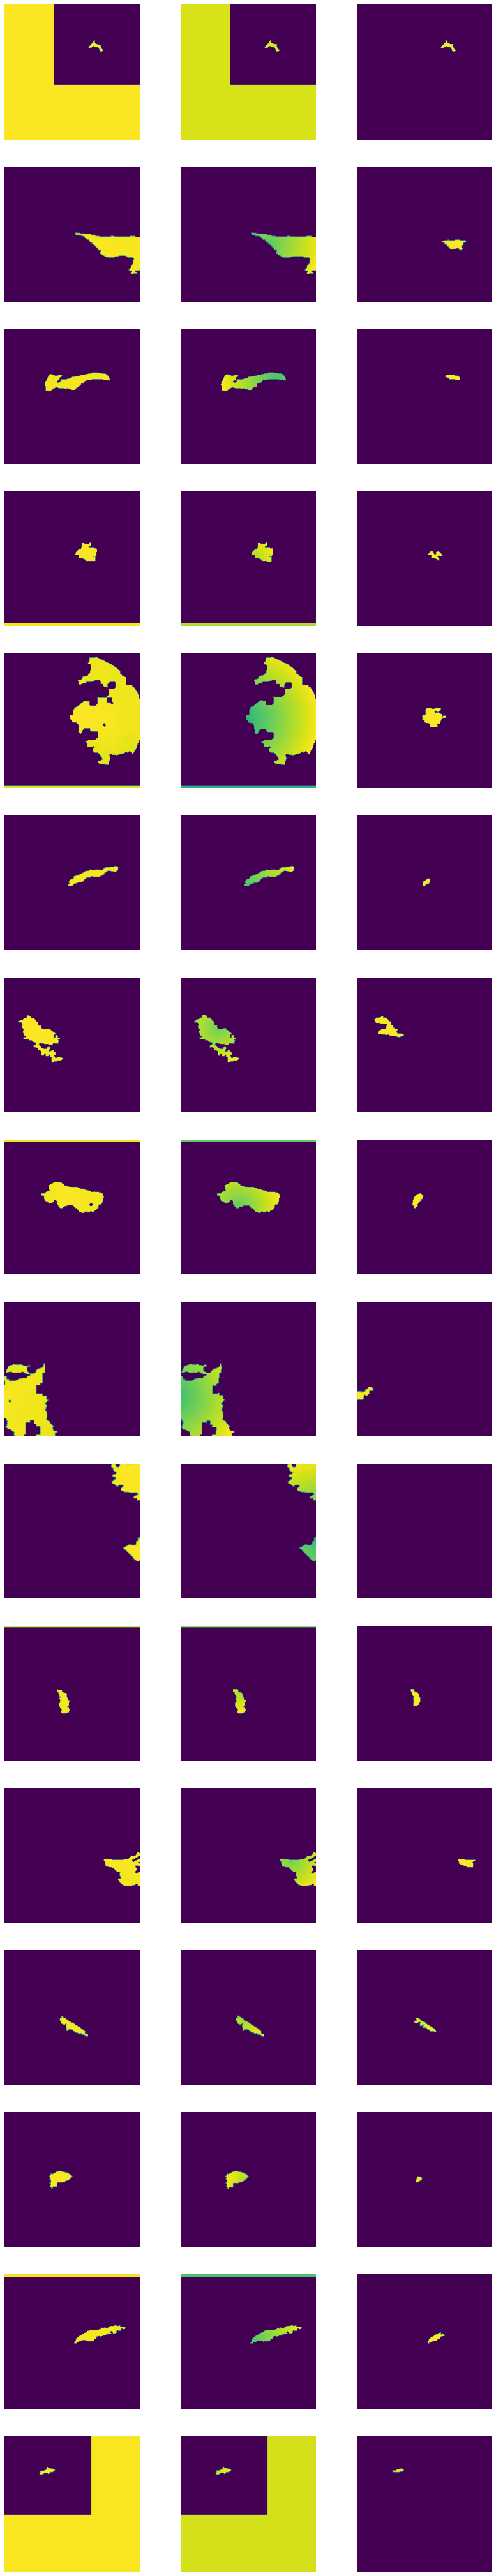

In [9]:
for _ in range(1): # _is a iterative symbol
    train_images, real_label = next(train_generator)

    ann = real_label[:,:,:,0]
    display_images(np.concatenate((train_images,real_label), axis = -1)) #,overlay

In [10]:
OPTIMIZER = adam
LOSS = focalTversky 

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'adam'
LOSS_NAME = 'focalTversky'

# Declare the path to the final model
# If you want to retrain an exising model then change the cell where model is declared. 
# This path is for storing a model after training.

timestr = time.strftime("%Y%m%d-%H%M")
chf = config.input_image_channel + config.input_label_channel
chs = reduce(lambda a,b: a+str(b), chf, '')


if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
model_path = os.path.join(config.model_path,'plumes_normalized_{}_{}_{}_{}_{}.h5'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs,config.input_shape[0]))
print(model_path)

I:\Unet\v1\v1\notebooks\saved_models\UNet\plumes_normalized_20220111-1442_adam_focalTversky_012_256.h5


In [11]:
# Define the model and compile it
model = UNet([config.BATCH_SIZE, *config.input_shape],config.input_label_channel)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, specificity, sensitivity, accuracy, PA, IoU_Pos, IoU_Neg, mIoU, F1_Score])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1216        Input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
# Define callbacks for the early stopping of training, LearningRateScheduler and model checkpointing
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard


checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

#reduceonplateau; It can be useful when using adam as optimizer
#Reduce learning rate when a metric has stopped improving (after some patience,reduce by a factor of 0.33, new_lr = lr * factor).
#cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=5, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=4, min_lr=1e-16)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=100)

log_dir = os.path.join(r'I:\Unet\v1\v1\notebooks\logs','UNet_{}_{}_{}_{}_{}'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs, config.input_shape[0]))
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_list = [checkpoint, tensorboard, early] #reduceLROnPlat is not required with adaDelta
print(callbacks_list)

[<tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x000001E7B764B0D0>, <tensorflow.python.keras.callbacks.TensorBoard object at 0x000001E7B764BD30>, <tensorflow.python.keras.callbacks.EarlyStopping object at 0x000001E7B764B550>]


In [13]:
loss_history = [model.fit(train_generator, 
                         steps_per_epoch=config.MAX_TRAIN_STEPS, 
                         epochs=config.NB_EPOCHS, 
                         validation_data=val_generator,
                         validation_steps=config.VALID_IMG_COUNT,
                         callbacks=callbacks_list,
                         workers=1,
#                          use_multiprocessing=True # the generator is not very thread safes
                        )]

Epoch 1/200
250/250 [==============================] - 74s 250ms/step - loss: 0.4623 - dice_coef: 0.9407 - dice_loss: 0.0593 - specificity: 0.9880 - sensitivity: 0.6358 - accuracy: 0.9859 - PA: 0.9859 - IoU_Pos: 0.3916 - IoU_Neg: 0.9858 - mIoU: 0.6887 - F1_Score: 0.5394 - val_loss: 0.3456 - val_dice_coef: 0.9691 - val_dice_loss: 0.0309 - val_specificity: 0.9986 - val_sensitivity: 0.6028 - val_accuracy: 0.9963 - val_PA: 0.9963 - val_IoU_Pos: 0.4776 - val_IoU_Neg: 0.9963 - val_mIoU: 0.7369 - val_F1_Score: 0.6445

Epoch 00001: val_loss improved from inf to 0.34559, saving model to I:\Unet\v1\v1\notebooks\saved_models\UNet\plumes_normalized_20220111-1442_adam_focalTversky_012_256.h5
Epoch 2/200
250/250 [==============================] - 60s 238ms/step - loss: 0.3326 - dice_coef: 0.9935 - dice_loss: 0.0065 - specificity: 0.9984 - sensitivity: 0.6529 - accuracy: 0.9963 - PA: 0.9963 - IoU_Pos: 0.5008 - IoU_Neg: 0.9963 - mIoU: 0.7486 - F1_Score: 0.6643 - val_loss: 0.2861 - val_dice_coef: 0.991

In [30]:
# Load model after training
# If you load a model with different python version, than you may run into a problem: https://github.com/keras-team/keras/issues/9595#issue-303471777

model = load_model(model_path, custom_objects={'focalTversky': LOSS, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'accuracy':accuracy , 'specificity': specificity, 'sensitivity':sensitivity, 'PA':PA, 'IoU_Pos':IoU_Pos, 'IoU_Neg':IoU_Neg, 'mIoU':mIoU, 'F1_Score':F1_Score}, compile=False)

# In case you want to use multiple GPU you can uncomment the following lines.
# from tensorflow.python.keras.utils import multi_gpu_model
# model = multi_gpu_model(model, gpus=2, cpu_merge=False)

model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, accuracy, specificity, sensitivity, PA, IoU_Pos, IoU_Neg, mIoU, F1_Score])

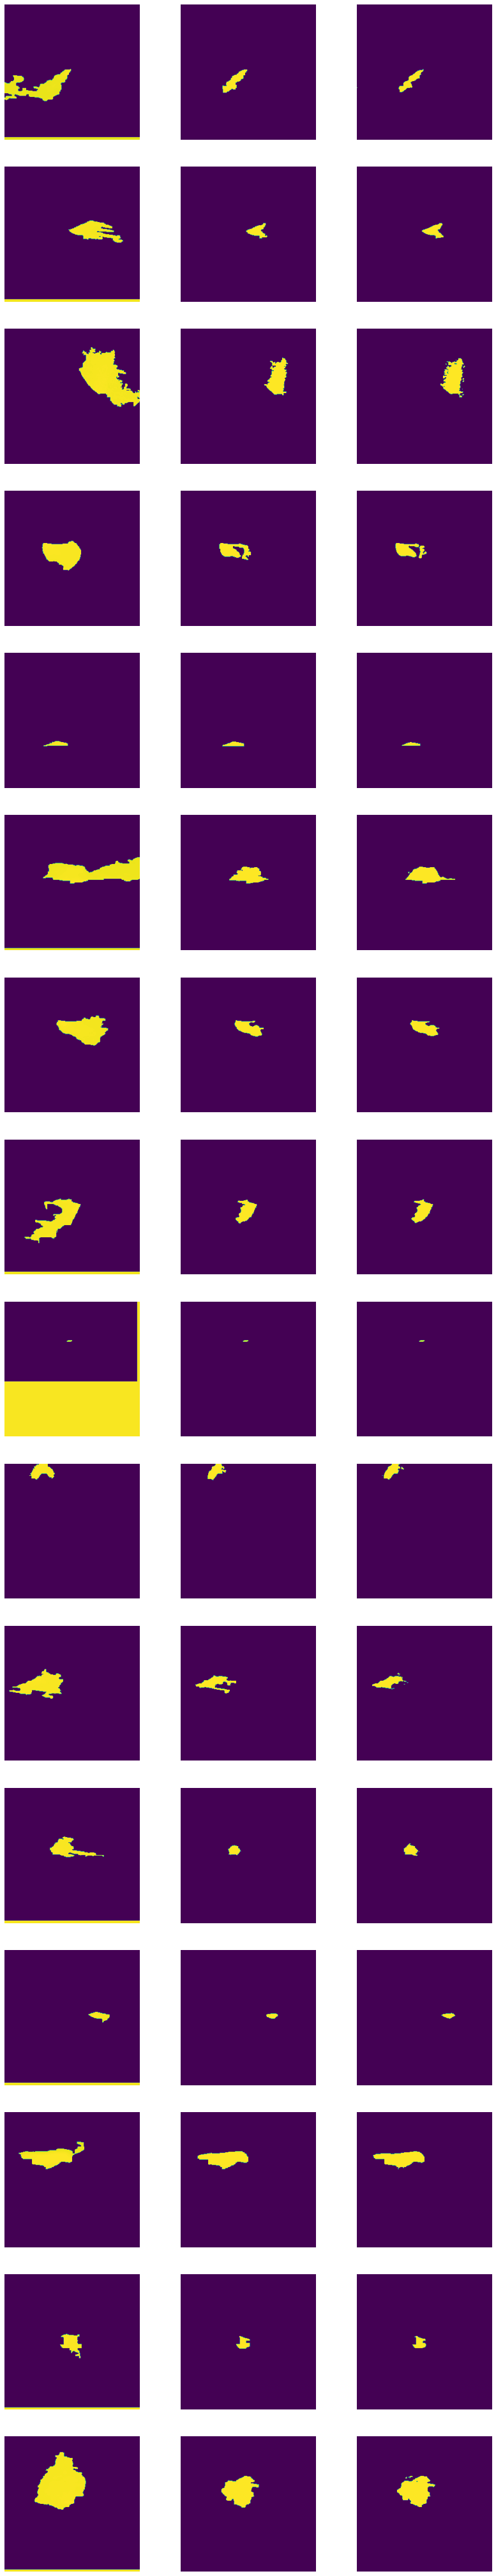

In [31]:
# Print one batch on the training/test data!
for i in range(1):
    test_images, real_label = next(test_generator)
    prediction = model.predict(test_images, steps=1)
    prediction[prediction>0.5]=1
    prediction[prediction<=0.5]=0
    display_images(np.concatenate((test_images, real_label, prediction), axis = -1))